 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [ ]:
# !pip install torchvision

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from tqdm import notebook
from torchvision import transforms
import torch.optim as optim
from torch import nn
import torch.nn.functional as F 
from collections import Counter

Скачаем обучающую и контрольную выборки.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes ={0:"T-shirt-top", 1:"Trouser", 2:"Pullover", 3:"Dress", 4:"Coat",
          5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

In [ ]:
#количество картинок в train и test
print(trainset.data.shape)
print(testset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [ ]:
# равномерно ли распределены
from collections import Counter
print(trainset.targets)
train_classes = [class_ for _,class_ in trainset]
print(Counter(train_classes))

tensor([9, 0, 0,  ..., 3, 0, 5])
Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})


In [ ]:
print(testset.targets)
test_classes = [class_ for _,class_ in testset]
print(Counter(test_classes))

tensor([9, 2, 1,  ..., 8, 1, 5])
Counter({9: 1000, 2: 1000, 1: 1000, 6: 1000, 4: 1000, 5: 1000, 7: 1000, 3: 1000, 8: 1000, 0: 1000})


Text(0.5, 1.0, 'Shirt')

<Figure size 432x288 with 0 Axes>

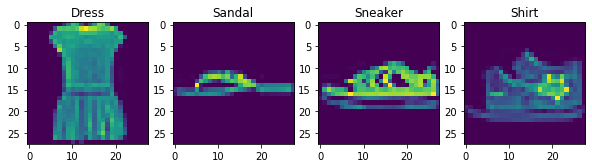

In [ ]:
# выведем несколько картинок
plt.figure()
f, axarr = plt.subplots(1, 4)
f.set_figwidth(10)
f.set_figheight(8)
axarr[0].imshow(trainset.data[3])
axarr[0].set_title(classes[int(trainset.targets[3])])
axarr[1].imshow(testset.data[8])
axarr[1].set_title(classes[int(trainset.targets[8])])
axarr[2].imshow(trainset.data[5500])
axarr[2].set_title(classes[int(trainset.targets[5500])])
axarr[3].imshow(testset.data[9999])
axarr[3].set_title(classes[int(trainset.targets[9999])])

In [ ]:
def calculate_accuracy(model, loader):
  total = 0
  correct = 0
  for images, labels in loader:
      images, labels = images.to(device), labels.to(device)
      y_pred = model(images)
      predicted = torch.max(y_pred, 1)[1].to(device)
      correct += (predicted == labels).sum()
      total += len(labels) 
  return(correct / total)

### **MLP Multy-Layer-Precepton**

In [ ]:
# Заметьте: класс наследуется от nn.Module
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        # вызов конструктора родителя
        super().__init__()
        self.input_fc = nn.Linear(input_dim, 256)
        self.hidden_fc = nn.Linear(256, 512)
        self.hidden_fc1 = nn.Linear(512, 1024)
        self.hidden_fc2 = nn.Linear(1024, 100)
        self.output_fc = nn.Linear(100, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        x = F.relu(self.input_fc(x))
        x = F.relu(self.hidden_fc(x))
        x = self.dropout(x)
        x = F.relu(self.hidden_fc1(x))
        x = self.dropout(x)
        x = F.relu(self.hidden_fc2(x))
        x = self.dropout(x)
        x = self.output_fc(x)
        return x

In [ ]:
mlp_model = SimpleMLP(28*28, 10)

In [ ]:
optimizer = optim.Adam(mlp_model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# using GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_model = mlp_model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
learning_rate = 1e-3

mlp_model_data = {"losses":[], "train_acc":[], "validation_acc":[]}
# итерируемся
for epoch in notebook.tqdm(range(8)):

    running_loss = 0.0
    for i, batch in enumerate(notebook.tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)     
        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = mlp_model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
    train_acc = calculate_accuracy(mlp_model, trainloader)
    validation_acc = calculate_accuracy(mlp_model, testloader)
    mlp_model_data["losses"].append( running_loss / 938)
    mlp_model_data["train_acc"].append(train_acc)
    mlp_model_data["validation_acc"].append(validation_acc)                               
    print('[%d, %5d] loss: %.3f - train accuracy: %3f - validation accuracy: %3f' %
        (epoch + 1, 938, running_loss / 938, train_acc, validation_acc))

print('Обучение закончено')

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

[1,   938] loss: 0.578 - train accuracy: 0.854383 - validation accuracy: 0.842400


  0%|          | 0/938 [00:00<?, ?it/s]

[2,   938] loss: 0.403 - train accuracy: 0.869233 - validation accuracy: 0.853500


  0%|          | 0/938 [00:00<?, ?it/s]

[3,   938] loss: 0.365 - train accuracy: 0.876100 - validation accuracy: 0.855400


  0%|          | 0/938 [00:00<?, ?it/s]

[4,   938] loss: 0.342 - train accuracy: 0.888867 - validation accuracy: 0.869500


  0%|          | 0/938 [00:00<?, ?it/s]

[5,   938] loss: 0.326 - train accuracy: 0.883300 - validation accuracy: 0.860500


  0%|          | 0/938 [00:00<?, ?it/s]

[6,   938] loss: 0.308 - train accuracy: 0.891700 - validation accuracy: 0.866800


  0%|          | 0/938 [00:00<?, ?it/s]

[7,   938] loss: 0.295 - train accuracy: 0.897983 - validation accuracy: 0.872700


  0%|          | 0/938 [00:00<?, ?it/s]

[8,   938] loss: 0.289 - train accuracy: 0.899150 - validation accuracy: 0.876200
Обучение закончено


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
total_acc = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        y_pred = mlp_model(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of T-shirt-top : 92 %
Accuracy of Trouser : 87 %
Accuracy of Pullover : 74 %
Accuracy of Dress : 87 %
Accuracy of  Coat : 88 %
Accuracy of Sandal : 98 %
Accuracy of Shirt : 59 %
Accuracy of Sneaker : 98 %
Accuracy of   Bag : 95 %
Accuracy of Ankle boot : 96 %


### **Сверточная нейронная сеть CNN**

In [ ]:
for data in trainloader:
    print(len(data))
    print('Images:',data[0].shape)
    print('Labels:', data[1].shape)
    break

2
Images: torch.Size([64, 1, 28, 28])
Labels: torch.Size([64])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F 
from sklearn.metrics import accuracy_score

In [ ]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора класса nn.Module()
        super(SimpleConvNet, self).__init__()

        # mine nixt tu zamen
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=24, kernel_size=3, padding='valid')
        self.bn1 = nn.BatchNorm2d(24)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='valid')
        self.bn4 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(10 * 10 * 64, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)

        self.dropout_point5 = nn.Dropout(p=0.5)
        self.dropout_point35 = nn.Dropout(p=0.35)
        # pooling maybe somehow
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.dropout_point35(x)
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout_point35(x)
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.dropout_point35(x)
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.dropout_point35(x)
        x = x.view(-1, 10 * 10 * 64)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout_point5(x)
        x = self.fc4(x)
        return x

In [ ]:
# объявляем сеть
net = SimpleConvNet()
net = net.to(device)

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
torch_cnn_data = {"losses":[], "train_acc":[], "validation_acc":[]}

# итерируемся
for epoch in notebook.tqdm(range(8)):

    running_loss = 0.0
    for i, batch in enumerate(notebook.tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()

    train_acc = calculate_accuracy(net, trainloader)
    validation_acc = calculate_accuracy(net, testloader)
    torch_cnn_data["losses"].append( running_loss / 938)
    torch_cnn_data["train_acc"].append(train_acc)
    torch_cnn_data["validation_acc"].append(validation_acc)                               
    print('[%d, %5d] loss: %.3f - train accuracy: %3f - validation accuracy: %3f' %
        (epoch + 1, 938, running_loss / 938, train_acc, validation_acc))
print('Обучение закончено')

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

[1,   938] loss: 0.485 - train accuracy: 0.883350 - validation accuracy: 0.875200


  0%|          | 0/938 [00:00<?, ?it/s]

[2,   938] loss: 0.334 - train accuracy: 0.900600 - validation accuracy: 0.892200


  0%|          | 0/938 [00:00<?, ?it/s]

[3,   938] loss: 0.290 - train accuracy: 0.906067 - validation accuracy: 0.889300


  0%|          | 0/938 [00:00<?, ?it/s]

[4,   938] loss: 0.261 - train accuracy: 0.917817 - validation accuracy: 0.899700


  0%|          | 0/938 [00:00<?, ?it/s]

[5,   938] loss: 0.240 - train accuracy: 0.921050 - validation accuracy: 0.899600


  0%|          | 0/938 [00:00<?, ?it/s]

[6,   938] loss: 0.229 - train accuracy: 0.926867 - validation accuracy: 0.903900


  0%|          | 0/938 [00:00<?, ?it/s]

[7,   938] loss: 0.207 - train accuracy: 0.936867 - validation accuracy: 0.907200


  0%|          | 0/938 [00:00<?, ?it/s]

[8,   938] loss: 0.193 - train accuracy: 0.934667 - validation accuracy: 0.905600
Обучение закончено


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
total_acc = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        labels = labels.to(device)
        images = images.to(device)
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i] 
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))    

Accuracy of T-shirt-top : 94 %
Accuracy of Trouser : 96 %
Accuracy of Pullover : 90 %
Accuracy of Dress : 87 %
Accuracy of  Coat : 93 %
Accuracy of Sandal : 100 %
Accuracy of Shirt : 66 %
Accuracy of Sneaker : 98 %
Accuracy of   Bag : 98 %
Accuracy of Ankle boot : 98 %


### **Keras CNN**

In [ ]:
import tensorflow as tf
X_test = tf.convert_to_tensor(testset.data.reshape(10000, 28, 28, 1).numpy())
X_train = tf.convert_to_tensor(trainset.data.reshape(60000, 28, 28, 1).numpy())
y_test = tf.convert_to_tensor(testset.targets.numpy())
y_train = tf.convert_to_tensor(trainset.targets.numpy())

In [ ]:
input_size = X_train[0].shape
print(input_size)

(28, 28, 1)


In [ ]:
from keras.layers import Conv2D
from keras import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, MaxPooling2D

In [ ]:
# Задаем пустую модель
conv_model = Sequential()

In [ ]:
# В начале добавляем сверточный слой, первый параметр - количество фильров (24),
# второй - размер "ядра" - окошка, перемещающегося по входному изображению (3,3),
# padding - добавление пикселей по краям изображения, чтобы сделать свертку на 
# крайних пикселях, режим `same` - повторение края
conv_model.add(Conv2D(24, (3, 3), padding='valid', input_shape=input_size, activation='relu'))

# Для сверточного слоя тоже нужна активация и ReLU подходит сюда так же, 
# как и для скрытого полносвязного слоя
conv_model.add(Conv2D(32, (3, 3), input_shape=input_size, activation='relu'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(tf.keras.layers.BatchNormalization())
conv_model.add(Dropout(0.3))

conv_model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_size, activation='relu'))
conv_model.add(Conv2D(64, (3, 3), padding='valid', input_shape=input_size, activation='relu'))

conv_model.add(MaxPooling2D(pool_size=(2, 2)))

conv_model.add(Dropout(0.3))

conv_model.add(Flatten())

# Добавляем полносвязный скрытый слой, вид активации можно указать сразу 
# в описании Dense слоя, в данном случае - ReLU

conv_model.add(Dense(1024, activation='relu'))
conv_model.add(Dense(512, activation='relu'))
conv_model.add(Dropout(0.3))
conv_model.add(Dense(256, activation='relu'))

conv_model.add(Dropout(0.4))

# Для выходного полносвязного слоя указываем количество итоговых классов и 
# softmax для активации
conv_model.add(Dense(10, activation='softmax'))

In [ ]:
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 24)        240       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        6944      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 64)       

In [ ]:
conv_model.compile(loss="sparse_categorical_crossentropy",
                   optimizer='nadam',
                   metrics=['accuracy'])

In [ ]:
cnn_history = conv_model.fit(X_train, y_train, epochs=8, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/8
469/469 [==============================] - 14s 25ms/step - loss: 0.5231 - accuracy: 0.8104 - val_loss: 0.3610 - val_accuracy: 0.8669
Epoch 2/8
469/469 [==============================] - 12s 25ms/step - loss: 0.3251 - accuracy: 0.8836 - val_loss: 0.2977 - val_accuracy: 0.8964
Epoch 3/8
469/469 [==============================] - 12s 25ms/step - loss: 0.2832 - accuracy: 0.8986 - val_loss: 0.2575 - val_accuracy: 0.9068
Epoch 4/8
469/469 [==============================] - 12s 25ms/step - loss: 0.2584 - accuracy: 0.9069 - val_loss: 0.2340 - val_accuracy: 0.9157
Epoch 5/8
469/469 [==============================] - 12s 25ms/step - loss: 0.2367 - accuracy: 0.9137 - val_loss: 0.2327 - val_accuracy: 0.9160
Epoch 6/8
469/469 [==============================] - 12s 25ms/step - loss: 0.2220 - accuracy: 0.9181 - val_loss: 0.2225 - val_accuracy: 0.9233
Epoch 7/8
469/469 [==============================] - 12s 25ms/step - loss: 0.2105 - accuracy: 0.9235 - val_loss: 0.2291 - val_accuracy: 0.9193

In [ ]:
y_predicted = conv_model.predict(X_test)
y_predicted_classes = np.argmax(y_predicted, axis=1)
y_predicted = {}
for i in range(10):
  y_predicted[i] = []

for i_ in range(len(y_predicted_classes)): 
    i = int(y_test[i_])
    if y_predicted_classes[i_] == i:
      y_predicted[i].append(1)
    else:
      y_predicted[i].append(0)

for i in range(10):
  values_pred = y_predicted[i]
  values = Counter(values_pred)
  print('Accuracy of %5s : %2d %%' % (
        classes[i],100 * values[1]/len(values_pred)))

Accuracy of T-shirt-top : 85 %
Accuracy of Trouser : 97 %
Accuracy of Pullover : 90 %
Accuracy of Dress : 92 %
Accuracy of  Coat : 89 %
Accuracy of Sandal : 97 %
Accuracy of Shirt : 76 %
Accuracy of Sneaker : 97 %
Accuracy of   Bag : 98 %
Accuracy of Ankle boot : 96 %


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Эта функция выводит confusion matrix.
    Нормализация может быть добавлена изменением значения флага 
    `normalize` на `True`
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

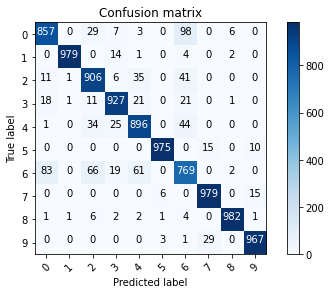

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_test,y_predicted_classes)
plot_confusion_matrix(confusion_mtx, classes = range(10))

Посмотрим врагам в лицо 

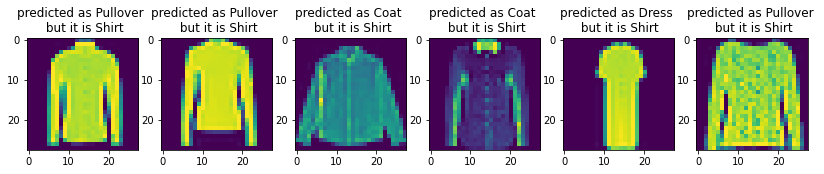

In [ ]:
img_count = 6
f, ax = plt.subplots(1, img_count)
f.set_figwidth(14)
f.set_figheight(6)
for i in range(len(y_test)):
  class_ = y_test[i]
  if class_ == 6 and class_ != y_predicted_classes[i]:
    img_count -= 1
    ax[img_count].set_title("predicted as {} \n but it is {}".format(classes[y_predicted_classes[i]], classes[6]))
    ax[img_count].imshow(testset.data[i]) 
    if img_count == 0:
      break

### **Сравнение моделей**

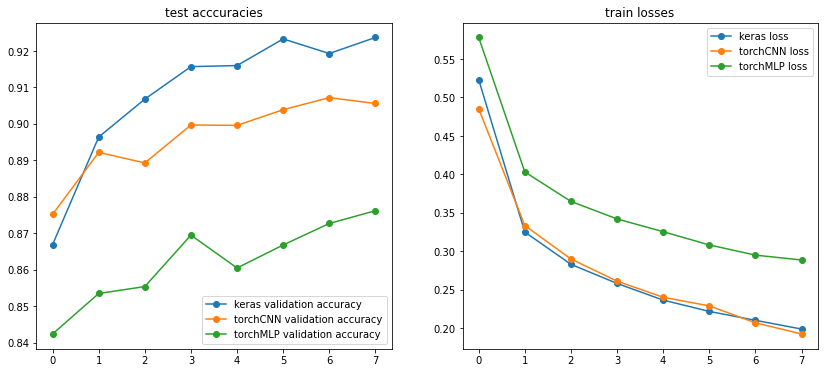

In [ ]:
f, axarr = plt.subplots(1, 2)
f.set_figwidth(14)
f.set_figheight(6)
axarr[0].plot(cnn_history.history['val_accuracy'], '-o', label='keras validation accuracy')
axarr[0].plot(torch_cnn_data['validation_acc'], '-o', label='torchCNN validation accuracy')
axarr[0].plot(mlp_model_data['validation_acc'], '-o', label='torchMLP validation accuracy')
axarr[0].set_title('test acccuracies')
axarr[0].legend();
axarr[1].plot(cnn_history.history['loss'], '-o', label='keras loss')
axarr[1].plot(torch_cnn_data['losses'], '-o', label='torchCNN loss')
axarr[1].plot(mlp_model_data['losses'], '-o', label='torchMLP loss')
axarr[1].set_title('train losses')
axarr[1].legend();

Если сравнивать MLP и CNN модели то можно увидеть что у сверточной нейронной сети получилось достигнуть большей точности. Так как она облададет преимушеством, которое заключается в том, что CNN позволяет находить и фильтровать патерны вне зависимости от того где на изображении они находятся.

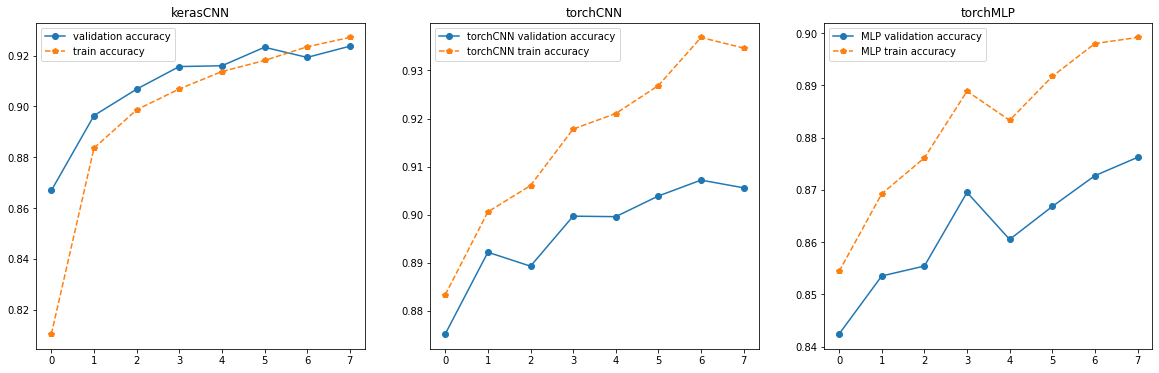

In [ ]:
f, axarr = plt.subplots(1, 3)
f.set_figwidth(20)
f.set_figheight(6)
axarr[0].plot(cnn_history.history['val_accuracy'], '-o', label='validation accuracy')
axarr[0].plot(cnn_history.history['accuracy'], '--p', label='train accuracy')
axarr[0].set_title('kerasCNN')
axarr[0].legend();
axarr[2].plot(mlp_model_data['validation_acc'], '-o', label='MLP validation accuracy')
axarr[2].plot(mlp_model_data['train_acc'], '--p', label='MLP train accuracy')
axarr[2].set_title('torchMLP')
axarr[2].legend();
axarr[1].plot(torch_cnn_data['validation_acc'], '-o', label='torchCNN validation accuracy')
axarr[1].plot(torch_cnn_data['train_acc'], '--p', label='torchCNN train accuracy')
axarr[1].set_title('torchCNN')
axarr[1].legend();